<a href="https://colab.research.google.com/github/HarishAggarwal001/AI-learning/blob/main/Thin_Plate_Spline_Motion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# !git clone https://github.com/yoyo-nb/Thin-Plate-Spline-Motion-Model.git 

In [34]:
# cd Thin-Plate-Spline-Motion-Model

In [35]:
# !mkdir checkpoints
# !wget -c https://cloud.tsinghua.edu.cn/f/da8d61d012014b12a9e4/?dl=1 -O checkpoints/vox.pth.tar
# #!wget -c https://cloud.tsinghua.edu.cn/f/483ef53650b14ac7ae70/?dl=1 -O checkpoints/ted.pth.tar
# #!wget -c https://cloud.tsinghua.edu.cn/f/9ec01fa4aaef423c8c02/?dl=1 -O checkpoints/taichi.pth.tar
# #!wget -c https://cloud.tsinghua.edu.cn/f/cd411b334a2e49cdb1e2/?dl=1 -O checkpoints/mgif.pth.tar

In [40]:
import torch

# edit the config
device = torch.device('cuda:0')
dataset_name = 'vox' # ['vox', 'taichi', 'ted', 'mgif']
source_image_path = './assets/source.png'
driving_video_path = './assets/driving.mp4'
output_video_path = './generated.mp4'
config_path = 'config/vox-256.yaml'
checkpoint_path = 'checkpoints/vox.pth.tar'
predict_mode = 'relative' # ['standard', 'relative', 'avd']
find_best_frame = False # when use the relative mode to animate a face, use 'find_best_frame=True' can get better quality result

pixel = 256 # for vox, taichi and mgif, the resolution is 256*256
if(dataset_name == 'ted'): # for ted, the resolution is 384*384
    pixel = 384

if find_best_frame:
  !pip install face_alignment

In [41]:
try:
  import imageio
  import imageio_ffmpeg
except:
  !pip install imageio_ffmpeg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
import os

warnings.filterwarnings("ignore")

source_image = imageio.imread(source_image_path)
reader = imageio.get_reader(driving_video_path)

source_image = resize(source_image, (pixel, pixel))[..., :3]

fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

driving_video = [resize(frame, (pixel, pixel))[..., :3] for frame in driving_video]

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image, driving_video).to_html5_video())

In [42]:
from demo import load_checkpoints
inpainting, kp_detector, dense_motion_network, avd_network = load_checkpoints(config_path = config_path, checkpoint_path = checkpoint_path, device = device)

In [43]:
from demo import make_animation
from skimage import img_as_ubyte

if predict_mode=='relative' and find_best_frame:
    from demo import find_best_frame as _find
    i = _find(source_image, driving_video, device.type=='cpu')
    print ("Best frame: " + str(i))
    driving_forward = driving_video[i:]
    driving_backward = driving_video[:(i+1)][::-1]
    predictions_forward = make_animation(source_image, driving_forward, inpainting, kp_detector, dense_motion_network, avd_network, device = device, mode = predict_mode)
    predictions_backward = make_animation(source_image, driving_backward, inpainting, kp_detector, dense_motion_network, avd_network, device = device, mode = predict_mode)
    predictions = predictions_backward[::-1] + predictions_forward[1:]
else:
    predictions = make_animation(source_image, driving_video, inpainting, kp_detector, dense_motion_network, avd_network, device = device, mode = predict_mode)

#save resulting video
imageio.mimsave(output_video_path, [img_as_ubyte(frame) for frame in predictions], fps=fps)

HTML(display(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 169/169 [00:11<00:00, 14.24it/s]


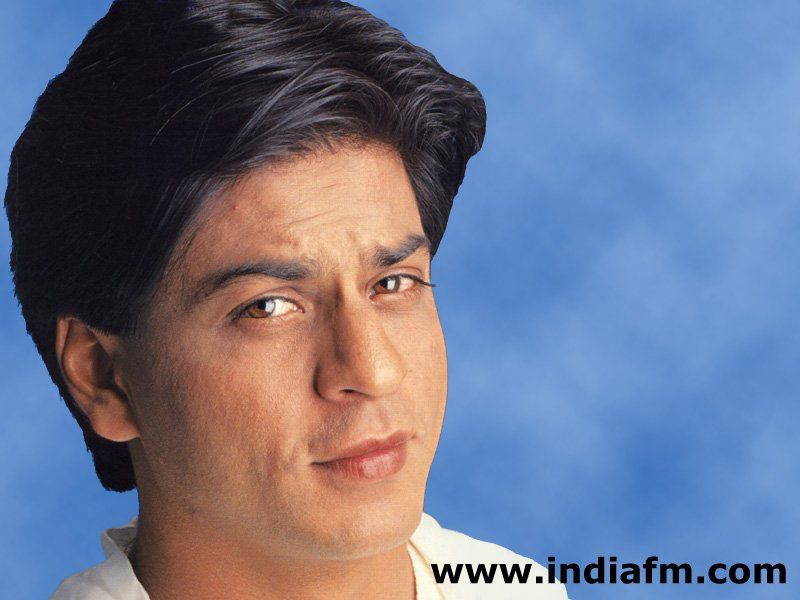

In [39]:
# from PIL import Image

# #read the image
# im = Image.open(source_image_path)

# #show image
# im.show()